# 特異スペクトル変換法による時系列データの異常部位検知

## 1. 特異スペクトル変換法の理解

### 概要

時系列データにおいて、ある時点（区間）の「特徴」を定義・数値化できれば、その変化を分析することで異常部位の特定ができそうである。<br>
特異スペクトル変換法は、ある時点における「過去の情報（履歴行列）」と「その時点周辺の情報（テスト行列）」の差異を「特徴」と捉えて、両者の「違い」の変化を分析する手法である。<br>
特異スペクトル変換法の手順は次の通り。<br>
- 時系列データのある時刻tについて、
    - 時刻t以降の隣接する時刻の並びを特定幅でスライスして「スライド窓」を取り出す
    - 時刻tより前の隣接する過去データの並びを特定幅でスライスして部分時系列データを取り出す（履歴ベクトル）
    - 時刻tを跨いで特定幅でスライスした部分時系列データを取り出す（テストベクトル）
    - スライド窓内の各時刻について同様の操作を繰り返す
    - 各時刻の履歴ベクトルを縦ベクトルとして並べて、「履歴行列」を作成する
    - 同様に、テストベクトルを縦ベクトルとして並べて、「テスト行列」を作成する
    - 履歴行列およびテスト行列を特異値分解して、左特異ベクトルを優先度順に並べて構成した特徴行列を作成する
    - それぞれの特徴行列の差異を、双方の距離（内積）として求め、変化度を計算する

### 履歴行列とテスト行列のイメージ

<b>直感的なイメージ</b><br>
特異スペクトル変換法によるデータ加工手順の直感的なイメージは次の通りだが・・・<br>

![pic1](./pic/pic1.png)

<b>実際のプログラム手順</b><br>
上記の履歴行列およびテスト行列を得るために、プログラムでは直感的な手順とは異なる、効率的な手順でデータ加工を行う。<br>
![pic2](./pic/pic2.png)

## 2. 異常部位の検知

### 時系列データの異常部位を検知する（その１）

下記からデータをダウンロードして、異常部位周辺を抽出加工。<br>
- データの取得元（心電図）<br>
<a href="http://www.cs.ucr.edu/~eamonn/discords/qtdbsel102.txt"> http://www.cs.ucr.edu/~eamonn/discords/qtdbsel102.txt</a><br>

同期した二つの時系列データが記録されているので、それぞれをについて、異常部位周辺を抽出。<br>
先ずは一つ目の波形から分析する。

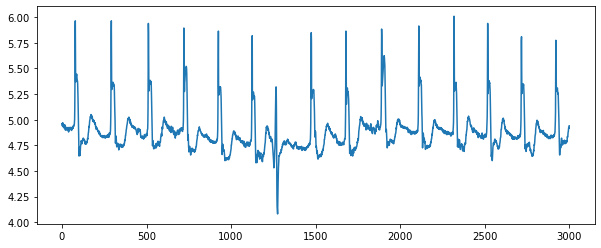

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline

# データ読み込み
df = pd.read_csv("./ecg_1.txt")
ecg = df.to_numpy()
#ecg = np.array(pd.read_csv("./ecg_1.txt"))
#ecg = np.array(pd.read_csv("./anomaly_detection_data/cardiogram.csv").ecg2)

# プロット
plt.figure(figsize=(10, 4))
plt.plot(ecg);

スライド窓幅の調整目安：<br>周期（約220）に対してピーク波の幅（約20）が狭いので、感度を上げるためにピーク波幅を目安にスライド窓幅を調整することにする。

In [2]:
def get_hist_test_matrix(data, W, n, k, L):
    """ 時系列データから各時刻の履歴行列とテスト行列を作成する
    Parameters
    ----------
    ts: numpy配列
    　　　　時系列データ
    W: int
    　　　　スライド幅
    n: int
        履歴行列の列数
    k:　int
        テスト行列の列数
    L: int
        ラグ
    """
#     # n, k, Lの指定が無い場合、次の値を設定
#     if n == 0:
#         n = W // 2
#         k = W // 2
#         L = W // 4
    
    # 軸を変換：データ数を列方向にしてスライス
    ts = data.reshape(1, -1)
    
    # tsからW幅の部分時系列データを作成
    sub_ts = ts[:, :-W]
    for m in range(W - 1):
        sub_ts = np.concatenate((sub_ts, ts[:, m + 1:m + 1 - W]), axis=0)
    sub_ts = np.transpose(sub_ts)  # shape: (N - W, W) = (2960, 40) , Nは全データ数3000
    
    # 部分時系列データを連結出来るように0軸追加：3次元化
    sub_ts_3d = sub_ts[np.newaxis, :]  # shape: (1, N - W, W) = (1, 2960, 40)
    
    # 履歴行列を作成
    H_hist = np.array(sub_ts_3d[:, :-(n + L), :])
    for i in range(n - 1):
        H_hist = np.concatenate((H_hist,
                               sub_ts_3d[:, i + 1:i + 1 -(n + L), :]),
                               axis=0)
    # 軸を入れ替える： axis=(1, 2, 0)
    #     変更前shape: (n, (N - W) - (n + L), W) = (20, 2930, 40)
    #     変更後shpae: ((N - W) - (n + L), W, n) = (2930, 40, 20)
    H_hist = np.transpose(H_hist, axes=(1, 2, 0))
    
    #テスト行列を作成
    H_test = np.array(sub_ts_3d[:, n + L - k:-k, :])
    for i in range(k - 1):
        H_test = np.concatenate((H_test,
                                sub_ts_3d[:, i + 1 + (n + L - k): i + 1 - k ]),
                                axis=0)
    # 軸を入れ替える： axis=(1, 2, 0)
    #     変更前shape: (k, (N - W) - (n + L), W) = (20, 2930, 40)
    #     変更後shpae: ((N - W) - (n + L), W, n) = (2930, 40, 20)
    H_test = np.transpose(H_test, axes=(1, 2, 0))
    
    return H_hist, H_test

# 履歴行列とテスト行列を取得
W = 20
n = W // 2
k = W // 2
L = W // 4
H_hist, H_test = get_hist_test_matrix(ecg, W, n, k, L)

# 履歴行列の特異値分解
U_hist, S_hist, V_hist = np.linalg.svd(H_hist)

# テスト行列の特異値分解
U_test, S_test, V_test = np.linalg.svd(H_test)

# 履歴行列のshapeを確認
print("U_hist: ", U_hist.shape)
print("S_hist", S_hist.shape)
print("V_hist:", V_hist.shape)

U_hist:  (2965, 20, 20)
S_hist (2965, 10)
V_hist: (2965, 10, 10)


抽出する特異ベクトルの個数を見積もるために、特異値の寄与率を目安とする。

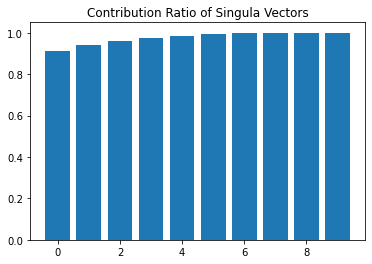

In [3]:
# 特異値の累積寄与率を確認：時点"500"をサンプリング
plt.figure()
plt.title("Contribution Ratio of Singula Vectors")
plt.bar(range(S_hist.shape[1]), np.cumsum(S_hist[500]) / np.sum(S_hist[500]))
plt.show();

上位一番目の特異ベクトルだけで寄与率が約90%に達している。<br>
全時点ではどうか。

In [4]:
# 全時点における第1特異ベクトルの寄与率の最大値と最小値を確認
cum = S_hist.sum(axis=1)
first = S_hist[:, 0]
print("第1特異ベクトルの寄与率：\n")
print("- 最大値：", max([f/c for f, c in zip(first, cum)]))
print("- 最小値：", min([f/c for f, c in zip(first, cum)]))

第1特異ベクトルの寄与率：

- 最大値： 0.9973836037841468
- 最小値： 0.8999632201861376


どの時点でも、第1特異ベクトルの寄与率だけで、ほぼ90%以上。<br>
テスト行列についても、履歴行列と作成過程が同じため、同様。<br>
先ずは、第1特異スペクトルのみを使用して、変化度を分析する。

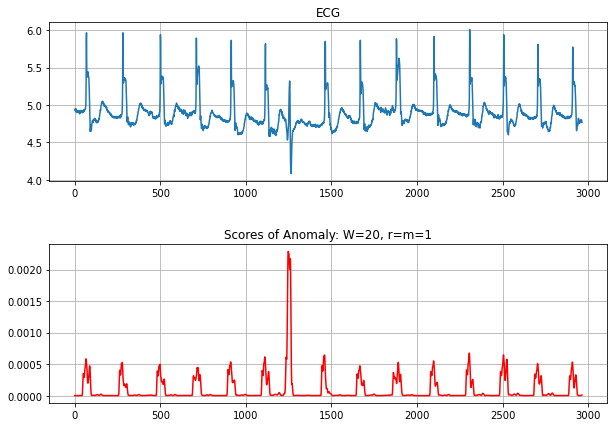

In [5]:
def get_anomaly_scores(H_hist, H_test, r, m):
    """ 履歴行列およびテスト行列を特異値分解し、変化度を計算する
    Parameters
    ----------
    H_hist: numpy array
        履歴行列
    H_test: numpy array
        テスト行列
    r: int
        特異ベクトルの上位階数（履歴行列）
    m: int
        特異ベクトルの上位階数（テスト行列）
    """
    # 時点ごとに、履歴行列とテスト行列を特異値分解
    U_hist, S_hist, V_hist = np.linalg.svd(H_hist)
    U_test, S_test, V_test = np.linalg.svd(H_test)

    # 時点ごとに、履歴行列とテスト行列の特異ベクトルを優先度順に採取
    U_hist = U_hist[:, :, :r]
    U_test = U_test[:, :, :m]

    # 時点ごとに、変化度を計算
    score_list = []    
    for X_hist, X_test in zip(U_hist, U_test):
        # 特異ベクトルから作成した行列同士の距離（内積）
        norm = np.linalg.norm(np.matmul(X_hist.T, X_test), ord=2)
        
        # 変化度(1 - norm)
        score_list.append(1 - norm)

    # 変化度のリストを戻す
    return np.array(score_list)


# 履歴行列とテスト行列を取得
W = 20
n = W // 2
k = W // 2
L = W // 4
H_hist, H_test = get_hist_test_matrix(ecg, W, n, k, L)

# 変化度を計算
scores = get_anomaly_scores(H_hist, H_test, 1, 1)

# 原波形をプロット
plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.4)
plt.title("ECG")
plt.grid(True)
plt.plot(range(scores.size), ecg[n:-(W + L)]) # 先頭nと最後尾W+Lの時点を除く

# 変化度をプロット
plt.subplot(2, 1, 2)
plt.title("Scores of Anomaly: W=20, r=m=1")
plt.grid(True)
plt.plot(range(scores.size), scores, color='r')

plt.show();

異常部位の変化度が際立っており、検知できる。<br>
スライド窓幅を広げたらどうか。

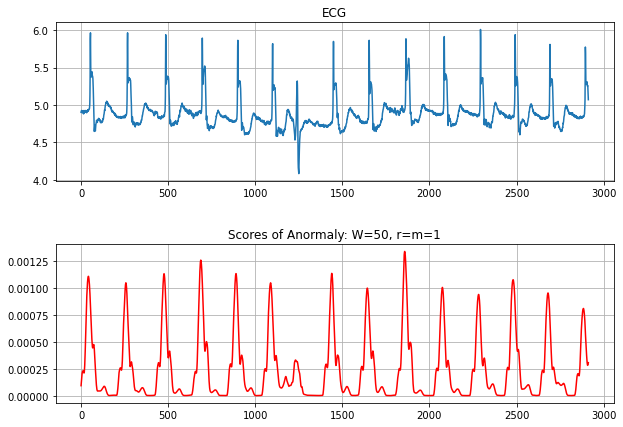

In [6]:
# 履歴行列とテスト行列を取得
W = 50
n = W // 2
k = W // 2
L = W // 4
H_hist, H_test = get_hist_test_matrix(ecg, W, n, k, L)

# 変化度を計算
scores = get_anomaly_scores(H_hist, H_test, 1, 1)  # 特異ベクトルの階数"1"

# 原波形をプロット
plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.4)
plt.title("ECG")
plt.grid(True)
plt.plot(range(scores.size), ecg[n:-(W + L)]) # 先頭nと最後尾W+Lの時点を除く

# 変化度をプロット
plt.subplot(2, 1, 2)
plt.title("Scores of Anormaly: W=50, r=m=1")
plt.grid(True)
plt.plot(range(scores.size), scores, color='r')

plt.show();

変化度からは異常部位の区別がつかず、検知できない。<br>
特異ベクトルの寄与度を確認してみる。

U_hist:  (2913, 50, 50)
S_hist (2913, 25)
V_hist: (2913, 25, 25)


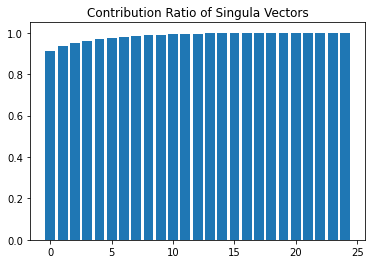

第1特異ベクトルの寄与率：

- 最大値： 0.9934962668508923
- 最小値： 0.862551594356216


In [7]:
# 履歴行列とテスト行列を取得
W = 50
n = W // 2
k = W // 2
L = W // 4
H_hist, H_test = get_hist_test_matrix(ecg, W, n, k, L)

# 履歴行列の特異値分解
U_hist, S_hist, V_hist = np.linalg.svd(H_hist)

# テスト行列の特異値分解
U_test, S_test, V_test = np.linalg.svd(H_test)

# 履歴行列のshapeを確認
print("U_hist: ", U_hist.shape)
print("S_hist", S_hist.shape)
print("V_hist:", V_hist.shape)

# 特異値の累積寄与率を確認：時点"500"をサンプリング
plt.figure()
plt.title("Contribution Ratio of Singula Vectors")
plt.bar(range(S_hist.shape[1]), np.cumsum(S_hist[500]) / np.sum(S_hist[500]))
plt.show();

# 全時点における第1特異ベクトルの寄与率の最大値と最小値を確認
cum = S_hist.sum(axis=1)
first = S_hist[:, 0]
print("第1特異ベクトルの寄与率：\n")
print("- 最大値：", max([f/c for f, c in zip(first, cum)]))
print("- 最小値：", min([f/c for f, c in zip(first, cum)]))

スライド窓幅20の場合に比べて、若干、第1特異ベクトルの寄与度が低いため、上位二つの特異ベクトルを採用して、変化度を再計算してみる。

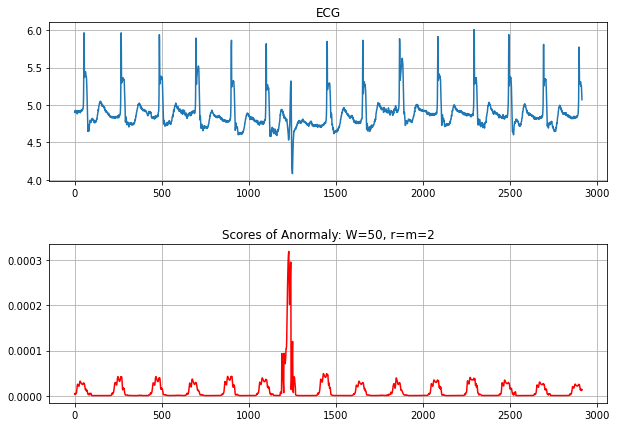

In [8]:
# 履歴行列とテスト行列を取得
W = 50
n = W // 2
k = W // 2
L = W // 4
H_hist, H_test = get_hist_test_matrix(ecg, W, n, k, L)

# 変化度を計算
scores = get_anomaly_scores(H_hist, H_test, 2, 2)  # 特異ベクトルの階数"2"

# 原波形をプロット
plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.4)
plt.title("ECG")
plt.grid(True)
plt.plot(range(scores.size), ecg[n:-(W + L)]) # 先頭nと最後尾W+Lの時点を除く

# 変化度をプロット
plt.subplot(2, 1, 2)
plt.title("Scores of Anormaly: W=50, r=m=2")
plt.grid(True)
plt.plot(range(scores.size), scores, c="r")

plt.show();

異常部位の変化度が際立ち、検知できるようになった。<br>
スライド窓幅50で取り出した部分時系列データでは、履歴行列とテスト行列の第2特異ベクトルに有効な「特徴」が含まれている、ということだろうか。

### 時系列データの異常部位を検知する（その２）

上述したように、ダウンロードしたデータには同期した二つの時系列データが記録されている。<br>
二つ目の時系列データについて、同様の分析を行うことにする。<br>
最初の波形で検知できたパラメータを踏襲して試してみる。<br>
先ずはスライド窓幅が20（特異ベクトル階数1）の場合。

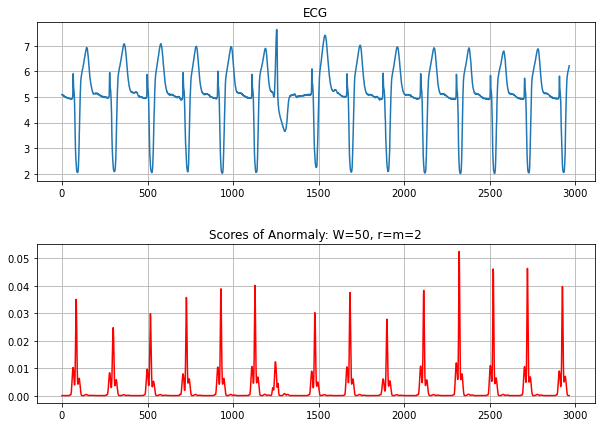

In [9]:
# データ読み込み
df = pd.read_csv("./ecg_2.txt")
ecg = df.to_numpy()

# 履歴行列とテスト行列を取得
W = 20
n = W // 2
k = W // 2
L = W // 4
H_hist, H_test = get_hist_test_matrix(ecg, W, n, k, L)

# 変化度を計算
scores = get_anomaly_scores(H_hist, H_test, 1, 1)  # 特異ベクトルの階数"1"

# 原波形をプロット
plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.4)
plt.title("ECG")
plt.grid(True)
plt.plot(range(scores.size), ecg[n:-(W + L)]) # 先頭nと最後尾W+Lの時点を除く

# 変化度をプロット
plt.subplot(2, 1, 2)
plt.title("Scores of Anormaly: W=50, r=m=2")
plt.grid(True)
plt.plot(range(scores.size), scores, c="r")

plt.show();

スライド窓幅20の場合は、変化度から異常部位が検知できない。<br>
スライド窓幅が小さく、正常周期と異常部位が区別できていないと推察する。<br>
スライド窓幅50の場合ではどうか。

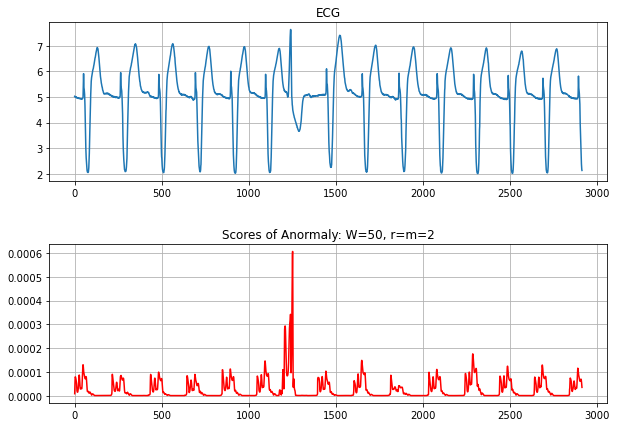

In [10]:
# データ読み込み
df = pd.read_csv("./ecg_2.txt")
ecg = df.to_numpy()

# 履歴行列とテスト行列を取得
W = 50
n = W // 2
k = W // 2
L = W // 4
H_hist, H_test = get_hist_test_matrix(ecg, W, n, k, L)

# 変化度を計算
scores = get_anomaly_scores(H_hist, H_test, 2, 2)  # 特異ベクトルの階数"2"

# 原波形をプロット
plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.4)
plt.title("ECG")
plt.grid(True)
plt.plot(range(scores.size), ecg[n:-(W + L)]) # 先頭nと最後尾W+Lの時点を除く

# 変化度をプロット
plt.subplot(2, 1, 2)
plt.title("Scores of Anormaly: W=50, r=m=2")
plt.grid(True)
plt.plot(range(scores.size), scores, c="r")

plt.show();

スライド窓幅50（特異ベクトル階数２）で検知できた。<br>
最初の波形と周期は同じだが、ピーク波幅が大きい事から、スライド窓幅を広げることで検知の感度がより適切になったと推察する。

## 3. 考察

- 周期的な波形の異常部位検知において、周期幅よりもピーク波幅を目安にスライド窓幅を調整すると有効であった
- 波形に対してスライド窓幅が小さい場合、正常波形と異常波形が区別できない（異常部位の変化度が高く無い）ことが観察された
- スライド窓幅を大きくすると、変化度の感度は低くなった
- スライド窓幅を大きくすると、履歴行列・テスト行列の列数として増加するに伴い、その時点の「特徴」が第２以降の特異ベクトルに分散する事から、特異ベクトルの採用階数を増やすことが有効と推察できる

## 4. さらなる理解に向けて

- パラメータ調整の自動化、適正化<br>
- 特異スペクトル変換法のメリットとデメリットの理解：
    - 異常検知が苦手なデータ
    - 特異値分解の計算負荷が高い：
        - <a href="http://ide-research.net/papers/2006_IBIS_Ide.ppt">特異値上位の特異ベクトル成分に寄与する範囲に履歴行列・テスト行列を圧縮する方法</a>
        - <a href="https://epubs.siam.org/doi/pdf/10.1137/1.9781611972771.54">Krylov部分空間の概念導入による高速化</a>